# Problem Description
Reinforcement Learning (RL) is a powerful machine learning paradigm where agents learn to make decisions by interacting with an environment. One of the most well-known applications of RL is training agents to perform tasks within game-like environments. In this project, we aim to explore how RL techniques, specifically Q-learning and Deep Q-learning (DQN), can be used to train intelligent agents in game environments provided by Gymnasium, an open-source library that facilitates RL experimentation.

Q-learning is a model-free RL algorithm that enables an agent to learn the optimal action-value function without requiring a model of the environment. However, Q-learning struggles with scalability, particularly in environments with large state spaces. To overcome this limitation, Deep Q-learning leverages deep neural networks to approximate the Q-values, enabling RL to tackle more complex environments with high-dimensional state spaces.

The primary goal of this project is to compare the performance of Q-learning and Deep Q-learning in game-based environments and to understand their strengths, weaknesses, and practical applications in training agents for decision-making tasks.

# Dependencies

In [1]:
!apt-get update
!apt-get install -y python-opengl ffmpeg
!apt-get install --upgrade cmake
!apt install swig xvfb
!pip install pyvirtualdisplay ez_setup gymnasium gymnasium[box2d]

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:5 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:6 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:8 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ Packages [66.7 kB]
Get:9 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,526 kB]
Get:10 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Get:11 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [2,911 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 Packages [3,748 kB]
Get:13 https://ppa.launchpadconte

In [5]:
import gymnasium as gym
from gymnasium.wrappers import RecordEpisodeStatistics, RecordVideo

import io
import base64
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from pyvirtualdisplay import Display
from IPython import display as display_f
from IPython.display import HTML

from collections import defaultdict, deque

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from keras import backend as K

# Utility functions

In [3]:
# Allow showing videos in notebook

display = Display(visible=0, size=(1400, 900))
display.start()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
def embed_video(video_file):

    video_data = io.open(video_file, 'r+b').read()
    encoded_data = base64.b64encode(video_data)

    display_f.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
                </video>'''.format(encoded_data.decode('ascii'))))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
def create_environment(name, record=False, record_path=None, **kwargs):
    env = gym.make(name, render_mode="rgb_array", **kwargs)
    if record:
      env = RecordVideo(env, record_path, episode_trigger=lambda x: True)  # Record all episodes if requested
    return env

# Random Agent

The simplest strategy that we can treat as some sort of a baseline is a random agent, which takes a random action at each step of the game. Our aim is to create an agent that will play better than this, otherwise we can't say it's learning anything new.

We will start with a simple game environment called FrozenLake, in which the agent has to navigate around the holes and reach the treasure, and there's also a random chance of slippage for every turn the agent takes.

In [6]:
env_name = "FrozenLake-v1"
env_args = {
    #"is_slippery": True,
    #"map_name": "8x8"
}

In [7]:
env = create_environment(env_name, record=True, record_path="./video_random", **env_args)
observation, info = env.reset()

episode_over = False
while not episode_over:
    action = env.action_space.sample()  # agent policy that uses the observation and info
    observation, reward, terminated, truncated, info = env.step(action)

    episode_over = terminated or truncated

env.close()

/usr/local/lib/python3.10/dist-packages/gymnasium/core.py:297: UserWarning: WARN: env.is_vector_env to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.is_vector_env` for environment variables or `env.get_attr('is_vector_env')` that will search the reminding wrappers.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists
/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/usr/lo

Moviepy - Building video /kaggle/working/video_random/rl-video-episode-0.mp4.
Moviepy - Writing video /kaggle/working/video_random/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /kaggle/working/video_random/rl-video-episode-0.mp4


In [6]:
embed_video("./video_random/rl-video-episode-0.mp4")

# Q Learning

## A Quick Overview

Q-learning is a model-free reinforcement learning algorithm that learns an optimal policy by iteratively updating a Q-table.  The Q-table stores estimated values (Q-values) for each state-action pair, representing the expected cumulative reward for taking a specific action in a particular state and following an optimal policy thereafter.  The algorithm updates Q-values based on observed rewards and future predicted rewards, gradually converging to the optimal action-value function.  This allows the agent to learn the best action to take in each state without needing a pre-defined model of the environment.

In [9]:
class QLearningAgent:
    def __init__(self, env, alpha=0.1, gamma=0.95, min_epsilon=0.01, trim_float=0):
        self.env = env
        self.q_table = defaultdict(lambda: defaultdict(lambda: 0))
        self.alpha = alpha
        self.gamma = gamma
        self.min_epsilon = min_epsilon
        self.dbg = False
        self.trim_float = trim_float # If observations are real numbers, we want to trim the number of trailing digits to narrow down the observation space
        self.action_space = env.action_space

    def hash_state(self, state):
        # Convert to numpy array if it's a single number
        if isinstance(state, (int, float)):
            state = np.array([state])
        else:
            state = np.asarray(state)

        # Discretize the state
        if self.trim_float:
            state = state * np.power(10, self.trim_float) // 1 / np.power(10, self.trim_float)

        # Convert to tuple for hashing
        return tuple(state)


    def choose_action(self, observation, epsilon):
        if np.random.random() < epsilon:
            return self.random_action()
        return self.greedy_action(observation)

    def greedy_action(self, observation):
        action_values = [self.q_table[observation][action]
                        for action in range(self.action_space.n)]
        # Add small random noise to break ties randomly
        return np.argmax(action_values + np.random.random(len(action_values)) * 1e-6)

    def random_action(self):
        return self.env.action_space.sample()

    def get_epsilon(self, episode, n_episodes):
        # Exponential decay for better exploration
        return max(self.min_epsilon,
                  np.exp(-3 * episode / n_episodes))

    def train(self, n_episodes=100, max_steps=1000):
        episode_rewards = []
        episode_lengths = []
        best_reward = float('-inf')

        for episode in tqdm(range(n_episodes)):
            total_reward = 0
            epsilon = self.get_epsilon(episode, n_episodes)
            observation, info = self.env.reset()

            for t in range(max_steps):
                observation = self.hash_state(observation)
                action = self.choose_action(observation, epsilon)

                next_observation, reward, terminated, truncated, info = self.env.step(action)
                next_observation = self.hash_state(next_observation)
                total_reward += reward

                # Q-learning update
                best_next_value = max(self.q_table[next_observation].values(),
                                    default=0)
                current_q = self.q_table[observation][action]
                target = reward + self.gamma * best_next_value
                self.q_table[observation][action] = current_q + self.alpha * (target - current_q)

                if self.dbg:
                    self._debug_print(observation, action, reward, current_q,
                                    self.q_table[observation][action])

                if terminated or truncated:
                    break

                observation = next_observation

            episode_rewards.append(total_reward)
            episode_lengths.append(t + 1)

            # Track best performance
            if total_reward > best_reward:
                best_reward = total_reward
                if self.dbg:
                    print(f"New best reward: {best_reward} at episode {episode}")

        return episode_rewards, episode_lengths

    def act(self, observation):
        observation = self.hash_state(observation)
        return self.greedy_action(observation)

    def _debug_print(self, observation, action, reward, old_q, new_q):
        print("------------")
        print(f"State: {observation}")
        print(f"Action: {action}")
        print(f"Reward: {reward}")
        print(f"Q-value changed: {old_q:.3f} -> {new_q:.3f}")
        print("------------")


In [10]:
# Training setup
env = create_environment(env_name, **env_args)
agent = QLearningAgent(env,
                      alpha=0.1,
                      gamma=0.99,
                      min_epsilon=0.01)

#agent.dbg = True
episode_rewards, episode_lengths = agent.train(n_episodes=2000)

100%|██████████| 2000/2000 [00:01<00:00, 1710.87it/s]


# Analysis of training

In [11]:
def plot_episode_stats(episode_rewards, episode_lengths, episode_losses=None):
    # Determine number of subplots needed
    n_plots = 3 if episode_losses is not None else 2

    # Create a figure with subplots
    plt.figure(figsize=(15, 4))

    # Calculate moving averages
    window_size = 100
    rewards_ma = np.convolve(episode_rewards, np.ones(window_size)/window_size, mode='valid')
    lengths_ma = np.convolve(episode_lengths, np.ones(window_size)/window_size, mode='valid')

    # Plot episode rewards
    plt.subplot(1, n_plots, 1)
    plt.plot(episode_rewards, alpha=0.3, color='blue', label='Raw')
    plt.plot(np.arange(window_size-1, len(episode_rewards)), rewards_ma,
            color='red', label=f'{window_size}-Episode Moving Average')
    plt.title('Episode Rewards')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.legend()

    # Plot episode lengths
    plt.subplot(1, n_plots, 2)
    plt.plot(episode_lengths, alpha=0.3, color='green', label='Raw')
    plt.plot(np.arange(window_size-1, len(episode_lengths)), lengths_ma,
            color='orange', label=f'{window_size}-Episode Moving Average')
    plt.title('Episode Lengths')
    plt.xlabel('Episode')
    plt.ylabel('Steps')
    plt.legend()

    # Plot episode losses if provided
    if episode_losses is not None:
        plt.subplot(1, n_plots, 3)
        losses_ma = np.convolve(episode_losses, np.ones(window_size)/window_size, mode='valid')
        plt.plot(episode_losses, alpha=0.3, color='purple', label='Raw')
        plt.plot(np.arange(window_size-1, len(episode_losses)), losses_ma,
                color='magenta', label=f'{window_size}-Episode Moving Average')
        plt.title('Training Loss')
        plt.xlabel('Episode')
        plt.ylabel('Loss')
        plt.legend()

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()

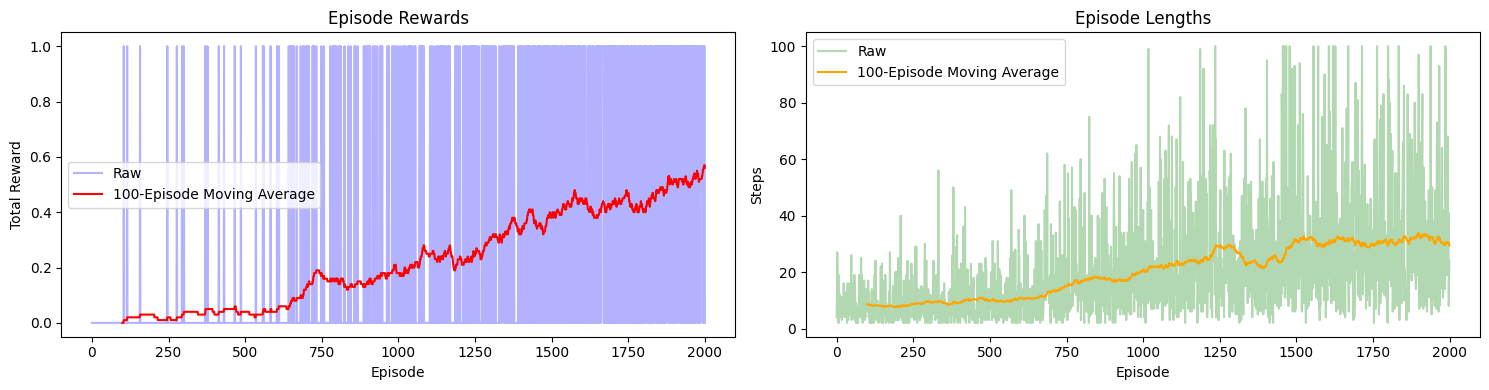

In [12]:

plot_episode_stats(episode_rewards, episode_lengths)

In [13]:
# DBG
# all_qvalues = pd.DataFrame([(state,action,agent.q_table[state][action]) for state in agent.q_table for action in range(env.action_space.n)], columns=['state','action','value'])
# all_qvalues.drop('state', axis=1).groupby('action').mean().plot(kind='bar') # DBG
# all_qvalues[all_qvalues['value'] != 0]['value'].hist()


The moving average of the total reward over the episodes, shows us that there's some learning happening for the agent. As it starts with exploration (high epsilon) the actions are mostly random and the average reward is low, but it increases as the episodes procceed and epsilon drops down to near zero (exploitation stage). Toward the last episodes we can see the best scores in achieved by the agent consistently in the moving average.

# Testing the trained agent

In [14]:
def test_agent(agent, env, n_episodes=5, max_steps=5000):
    episode_rewards = []
    episode_lengths = []

    for episode in range(n_episodes):
        total_reward = 0
        observation, info = env.reset()
        episode_over = False
        t = 0

        while not episode_over:
            action = agent.act(observation)
            observation, reward, terminated, truncated, info = env.step(action)
            total_reward += reward
            episode_over = terminated or truncated or t > max_steps
            t += 1

        episode_rewards.append(total_reward)
        episode_lengths.append(t)
        print(f"Episode {episode}: Reward = {total_reward:.2f}, Length = {t}")

    print("\nTest Results:")
    print(f"Average Reward: {np.mean(episode_rewards):.2f} ± {np.std(episode_rewards):.2f}")
    print(f"Average Length: {np.mean(episode_lengths):.2f} ± {np.std(episode_lengths):.2f}")

    return episode_rewards, episode_lengths


In [15]:
# Test the agent
env = create_environment(env_name, record=True, record_path="./video_qlearning", **env_args)
test_rewards, test_lengths = test_agent(agent, env, n_episodes=10)
env.close()

/usr/local/lib/python3.10/dist-packages/gymnasium/core.py:297: UserWarning: WARN: env.is_vector_env to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.is_vector_env` for environment variables or `env.get_attr('is_vector_env')` that will search the reminding wrappers.
  logger.warn(


Moviepy - Building video /kaggle/working/video_qlearning/rl-video-episode-0.mp4.
Moviepy - Writing video /kaggle/working/video_qlearning/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /kaggle/working/video_qlearning/rl-video-episode-0.mp4
Episode 0: Reward = 1.00, Length = 25
Moviepy - Building video /kaggle/working/video_qlearning/rl-video-episode-1.mp4.
Moviepy - Writing video /kaggle/working/video_qlearning/rl-video-episode-1.mp4



Moviepy - Done !
Moviepy - video ready /kaggle/working/video_qlearning/rl-video-episode-1.mp4
Episode 1: Reward = 0.00, Length = 49


Moviepy - Building video /kaggle/working/video_qlearning/rl-video-episode-2.mp4.
Moviepy - Writing video /kaggle/working/video_qlearning/rl-video-episode-2.mp4



Moviepy - Done !
Moviepy - video ready /kaggle/working/video_qlearning/rl-video-episode-2.mp4
Episode 2: Reward = 1.00, Length = 59
Moviepy - Building video /kaggle/working/video_qlearning/rl-video-episode-3.mp4.
Moviepy - Writing video /kaggle/working/video_qlearning/rl-video-episode-3.mp4



Moviepy - Done !
Moviepy - video ready /kaggle/working/video_qlearning/rl-video-episode-3.mp4
Episode 3: Reward = 0.00, Length = 34
Moviepy - Building video /kaggle/working/video_qlearning/rl-video-episode-4.mp4.
Moviepy - Writing video /kaggle/working/video_qlearning/rl-video-episode-4.mp4



Moviepy - Done !
Moviepy - video ready /kaggle/working/video_qlearning/rl-video-episode-4.mp4
Episode 4: Reward = 1.00, Length = 99
Moviepy - Building video /kaggle/working/video_qlearning/rl-video-episode-5.mp4.
Moviepy - Writing video /kaggle/working/video_qlearning/rl-video-episode-5.mp4



Moviepy - Done !
Moviepy - video ready /kaggle/working/video_qlearning/rl-video-episode-5.mp4
Episode 5: Reward = 1.00, Length = 32
Moviepy - Building video /kaggle/working/video_qlearning/rl-video-episode-6.mp4.
Moviepy - Writing video /kaggle/working/video_qlearning/rl-video-episode-6.mp4



Moviepy - Done !
Moviepy - video ready /kaggle/working/video_qlearning/rl-video-episode-6.mp4
Episode 6: Reward = 1.00, Length = 90
Moviepy - Building video /kaggle/working/video_qlearning/rl-video-episode-7.mp4.
Moviepy - Writing video /kaggle/working/video_qlearning/rl-video-episode-7.mp4



Moviepy - Done !
Moviepy - video ready /kaggle/working/video_qlearning/rl-video-episode-7.mp4
Episode 7: Reward = 1.00, Length = 26
Moviepy - Building video /kaggle/working/video_qlearning/rl-video-episode-8.mp4.
Moviepy - Writing video /kaggle/working/video_qlearning/rl-video-episode-8.mp4



Moviepy - Done !
Moviepy - video ready /kaggle/working/video_qlearning/rl-video-episode-8.mp4
Episode 8: Reward = 1.00, Length = 11
Moviepy - Building video /kaggle/working/video_qlearning/rl-video-episode-9.mp4.
Moviepy - Writing video /kaggle/working/video_qlearning/rl-video-episode-9.mp4



Moviepy - Done !
Moviepy - video ready /kaggle/working/video_qlearning/rl-video-episode-9.mp4
Episode 9: Reward = 1.00, Length = 24

Test Results:
Average Reward: 0.80 ± 0.40
Average Length: 44.90 ± 27.93


In [9]:

#embed_video("./video_qlearning/rl-video-episode-8.mp4")
embed_video("./video_qlearning/frozen-lake-rl-video-episode-8.mp4") # Restored overwritten vid for preview outside of kaggle


# Test results
It seems that the agent is pretty successful in that environment, it's able to win the game in most attempts.

The level of challenge is still quite low in this environment, and so it's good to see that there's some learning going on before we jump into harder challenges for the agent.

# Escalating the challenge

In [17]:
# Try a harder environment
env_name = "CartPole-v1"
env_args = {}  # No specific arguments needed for LunarLander

# Create and train the agent
env = create_environment(env_name, **env_args)
agent = QLearningAgent(env, alpha=0.2, gamma=0.95, min_epsilon=0.01, trim_float=1)
episode_rewards, episode_lengths = agent.train(n_episodes=5000, max_steps=1000)

100%|██████████| 5000/5000 [00:16<00:00, 310.11it/s]


Notice that in this environment, we had to heavily trim and discretize the state space with trim_float=1, as the problem gets more complex it will get harder to cover our sparse observations space, especially when it's continuous rather than discrete.

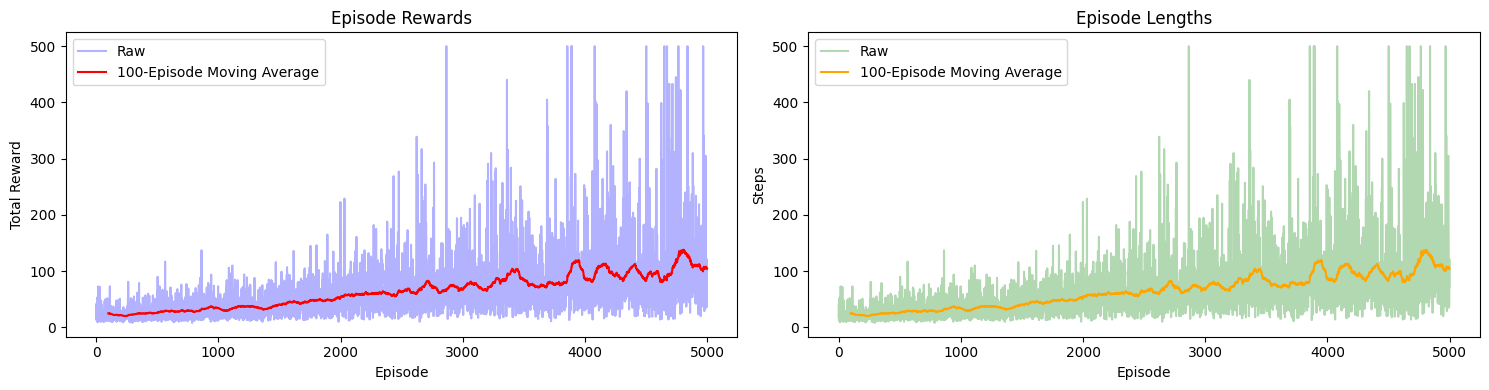

In [18]:
plot_episode_stats(episode_rewards, episode_lengths)

In this case it is quite hard to achieve higher rewards with just Q-learning, although we can see that there's some increase in total reward.

We also see that a few episodes toward the end got the maximum reward (500) for the CartPole game, but it's not very consistent since there are so many possible states.

In [19]:
# Test the agent
env = create_environment(env_name, record=True, record_path="./video_qlearning", **env_args)
test_rewards, test_lengths = test_agent(agent, env, n_episodes=10)
env.close()

/usr/local/lib/python3.10/dist-packages/gymnasium/wrappers/record_video.py:94: UserWarning: WARN: Overwriting existing videos at /kaggle/working/video_qlearning folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Moviepy - Building video /kaggle/working/video_qlearning/rl-video-episode-0.mp4.
Moviepy - Writing video /kaggle/working/video_qlearning/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /kaggle/working/video_qlearning/rl-video-episode-0.mp4
Episode 0: Reward = 117.00, Length = 117
Moviepy - Building video /kaggle/working/video_qlearning/rl-video-episode-1.mp4.
Moviepy - Writing video /kaggle/working/video_qlearning/rl-video-episode-1.mp4



Moviepy - Done !
Moviepy - video ready /kaggle/working/video_qlearning/rl-video-episode-1.mp4
Episode 1: Reward = 52.00, Length = 52
Moviepy - Building video /kaggle/working/video_qlearning/rl-video-episode-2.mp4.
Moviepy - Writing video /kaggle/working/video_qlearning/rl-video-episode-2.mp4



Moviepy - Done !
Moviepy - video ready /kaggle/working/video_qlearning/rl-video-episode-2.mp4
Episode 2: Reward = 76.00, Length = 76
Moviepy - Building video /kaggle/working/video_qlearning/rl-video-episode-3.mp4.
Moviepy - Writing video /kaggle/working/video_qlearning/rl-video-episode-3.mp4



Moviepy - Done !
Moviepy - video ready /kaggle/working/video_qlearning/rl-video-episode-3.mp4
Episode 3: Reward = 41.00, Length = 41
Moviepy - Building video /kaggle/working/video_qlearning/rl-video-episode-4.mp4.
Moviepy - Writing video /kaggle/working/video_qlearning/rl-video-episode-4.mp4



Moviepy - Done !
Moviepy - video ready /kaggle/working/video_qlearning/rl-video-episode-4.mp4
Episode 4: Reward = 127.00, Length = 127
Moviepy - Building video /kaggle/working/video_qlearning/rl-video-episode-5.mp4.
Moviepy - Writing video /kaggle/working/video_qlearning/rl-video-episode-5.mp4



Moviepy - Done !
Moviepy - video ready /kaggle/working/video_qlearning/rl-video-episode-5.mp4
Episode 5: Reward = 346.00, Length = 346
Moviepy - Building video /kaggle/working/video_qlearning/rl-video-episode-6.mp4.
Moviepy - Writing video /kaggle/working/video_qlearning/rl-video-episode-6.mp4



Moviepy - Done !
Moviepy - video ready /kaggle/working/video_qlearning/rl-video-episode-6.mp4
Episode 6: Reward = 168.00, Length = 168
Moviepy - Building video /kaggle/working/video_qlearning/rl-video-episode-7.mp4.
Moviepy - Writing video /kaggle/working/video_qlearning/rl-video-episode-7.mp4



Moviepy - Done !
Moviepy - video ready /kaggle/working/video_qlearning/rl-video-episode-7.mp4
Episode 7: Reward = 66.00, Length = 66
Moviepy - Building video /kaggle/working/video_qlearning/rl-video-episode-8.mp4.
Moviepy - Writing video /kaggle/working/video_qlearning/rl-video-episode-8.mp4



Moviepy - Done !
Moviepy - video ready /kaggle/working/video_qlearning/rl-video-episode-8.mp4
Episode 8: Reward = 114.00, Length = 114
Moviepy - Building video /kaggle/working/video_qlearning/rl-video-episode-9.mp4.
Moviepy - Writing video /kaggle/working/video_qlearning/rl-video-episode-9.mp4



Moviepy - Done !
Moviepy - video ready /kaggle/working/video_qlearning/rl-video-episode-9.mp4
Episode 9: Reward = 264.00, Length = 264

Test Results:
Average Reward: 137.10 ± 93.28
Average Length: 137.10 ± 93.28


In [8]:

embed_video("./video_qlearning/rl-video-episode-8.mp4")


# Deep Q Learning


Deep Q-learning (DQN) overcomes Q-learning's limitations with large state spaces.  Q-learning uses a table to store Q-values for each state-action pair, which becomes impractical for high-dimensional or continuous states. DQN uses a neural network to approximate the Q-value function, allowing it to handle complex environments more effectively.

In [21]:

class FrameStack:
    def __init__(self, n_frames=4):
        self.n_frames = n_frames
        self.frames = deque(maxlen=n_frames)

    def reset(self, initial_frame):
        self.frames.clear()
        for _ in range(self.n_frames):
            self.frames.append(initial_frame)
        return self.get_state()

    def add_frame(self, frame):
        self.frames.append(frame)
        return self.get_state()

    def get_state(self):
        return np.array(list(self.frames))

class DQNAgent:
    def __init__(self, env, memory_size=2000, batch_size=32, gamma=0.95,
                 epsilon=1.0, epsilon_min=0.01, epsilon_decay=0.995,
                 learning_rate=0.001, n_frames=4):
        self.env = env
        self.n_frames = n_frames
        self.frame_stack = FrameStack(n_frames)

        # Modified state size to account for frame stacking
        self.state_size = (n_frames,) + env.observation_space.shape
        self.action_size = env.action_space.n

        # Hyperparameters
        self.memory = deque(maxlen=memory_size)
        self.batch_size = batch_size
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.learning_rate = learning_rate

        # Neural Networks
        self.model = self._build_model()
        self.target_model = self._build_model()
        self.update_target_model()

        # Training metrics
        self.loss_history = []

    def _build_model(self):
        """Neural Network for Deep Q-learning with frame stacking"""
        model = Sequential([
            Dense(16, input_shape=self.state_size, activation='relu'),
            Flatten(),
            Dense(16, activation='relu'),
            Dense(self.action_size, activation='linear')
        ])
        model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate, beta_1=0.99))
        return model

    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state, training=False):
        if training and random.random() < self.epsilon:
            return random.randrange(self.action_size)

        state = np.expand_dims(state, axis=0)
        act_values = self.model.predict(state, verbose=0)
        return np.argmax(act_values[0])

    def replay(self):
        if len(self.memory) < self.batch_size:
            return 0

        minibatch = random.sample(self.memory, self.batch_size)

        states = np.array([i[0] for i in minibatch])
        actions = np.array([i[1] for i in minibatch])
        rewards = np.array([i[2] for i in minibatch])
        next_states = np.array([i[3] for i in minibatch])
        dones = np.array([i[4] for i in minibatch])

        targets = self.model.predict(states, verbose=0)
        target_next = self.target_model.predict(next_states, verbose=0)

        for i in range(self.batch_size):
            if dones[i]:
                targets[i][actions[i]] = rewards[i]
            else:
                targets[i][actions[i]] = rewards[i] + self.gamma * np.max(target_next[i])

        history = self.model.fit(states, targets, epochs=1, verbose=0)
        K.clear_session()
        
        loss = history.history['loss'][0]
        self.loss_history.append(loss)

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        return loss

    def train(self, n_episodes=1000, max_steps=500, train_freq=10, target_update_freq=10):
        episode_rewards = []
        episode_lengths = []
        episode_losses = []

        for episode in tqdm(range(n_episodes)):
            initial_state, _ = self.env.reset()
            state = self.frame_stack.reset(initial_state)
            total_reward = 0
            total_loss = 0

            for step in range(max_steps):
                action = self.act(state, training=True)
                next_obs, reward, terminated, truncated, _ = self.env.step(action)

                # Stack the new frame
                next_state = self.frame_stack.add_frame(next_obs)

                # Store experience
                self.remember(state, action, reward, next_state, terminated)

                # Train on batch, note that 
                if step % train_freq == 0:
                    loss = self.replay()
                    total_loss += loss if loss is not None else 0

                total_reward += reward
                state = next_state

                if terminated or truncated:
                    break

            if episode % target_update_freq == 0:
                self.update_target_model()

            episode_rewards.append(total_reward)
            episode_losses.append(total_loss)
            episode_lengths.append(step + 1)

            if episode % 100 == 0:
                print(f"Episode: {episode}, Reward: {total_reward}, Epsilon: {self.epsilon:.2f}")

        return episode_rewards, episode_lengths, episode_losses

    def save(self, filename):
        self.model.save(filename)

    def load(self, filename):
        self.model = tf.keras.models.load_model(filename)
        self.update_target_model()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
  0%|          | 0/2000 [00:00<?, ?it/s]

Episode: 0, Reward: 20.0, Epsilon: 1.00


  5%|▌         | 101/2000 [01:53<42:28,  1.34s/it]

Episode: 100, Reward: 21.0, Epsilon: 0.38


 10%|█         | 201/2000 [04:07<27:19,  1.10it/s]

Episode: 200, Reward: 10.0, Epsilon: 0.15


 15%|█▌        | 301/2000 [06:36<1:20:51,  2.86s/it]

Episode: 300, Reward: 41.0, Epsilon: 0.06


 20%|██        | 401/2000 [08:38<22:54,  1.16it/s]

Episode: 400, Reward: 9.0, Epsilon: 0.03


 25%|██▌       | 501/2000 [11:44<1:03:03,  2.52s/it]

Episode: 500, Reward: 18.0, Epsilon: 0.01


 30%|███       | 601/2000 [15:28<46:27,  1.99s/it]

Episode: 600, Reward: 26.0, Epsilon: 0.01


 35%|███▌      | 701/2000 [19:19<40:23,  1.87s/it]

Episode: 700, Reward: 16.0, Epsilon: 0.01


 40%|████      | 801/2000 [22:45<30:37,  1.53s/it]

Episode: 800, Reward: 19.0, Epsilon: 0.01


 45%|████▌     | 901/2000 [25:24<28:42,  1.57s/it]

Episode: 900, Reward: 13.0, Epsilon: 0.01


 50%|█████     | 1001/2000 [28:35<1:26:12,  5.18s/it]

Episode: 1000, Reward: 66.0, Epsilon: 0.01


 55%|█████▌    | 1101/2000 [32:26<27:40,  1.85s/it]

Episode: 1100, Reward: 22.0, Epsilon: 0.01


 60%|██████    | 1201/2000 [36:15<27:30,  2.07s/it]

Episode: 1200, Reward: 25.0, Epsilon: 0.01


 65%|██████▌   | 1301/2000 [40:25<27:49,  2.39s/it]

Episode: 1300, Reward: 23.0, Epsilon: 0.01


 70%|███████   | 1401/2000 [43:26<17:05,  1.71s/it]

Episode: 1400, Reward: 18.0, Epsilon: 0.01


 75%|███████▌  | 1501/2000 [48:00<28:05,  3.38s/it]

Episode: 1500, Reward: 30.0, Epsilon: 0.01


 80%|████████  | 1601/2000 [55:13<28:15,  4.25s/it]

Episode: 1600, Reward: 49.0, Epsilon: 0.01


 85%|████████▌ | 1701/2000 [1:05:30<34:17,  6.88s/it]

Episode: 1700, Reward: 80.0, Epsilon: 0.01


 90%|█████████ | 1801/2000 [1:23:03<40:49, 12.31s/it]

Episode: 1800, Reward: 107.0, Epsilon: 0.01


 95%|█████████▌| 1901/2000 [1:49:27<36:12, 21.95s/it]

Episode: 1900, Reward: 200.0, Epsilon: 0.01


100%|██████████| 2000/2000 [2:29:39<00:00,  4.49s/it]


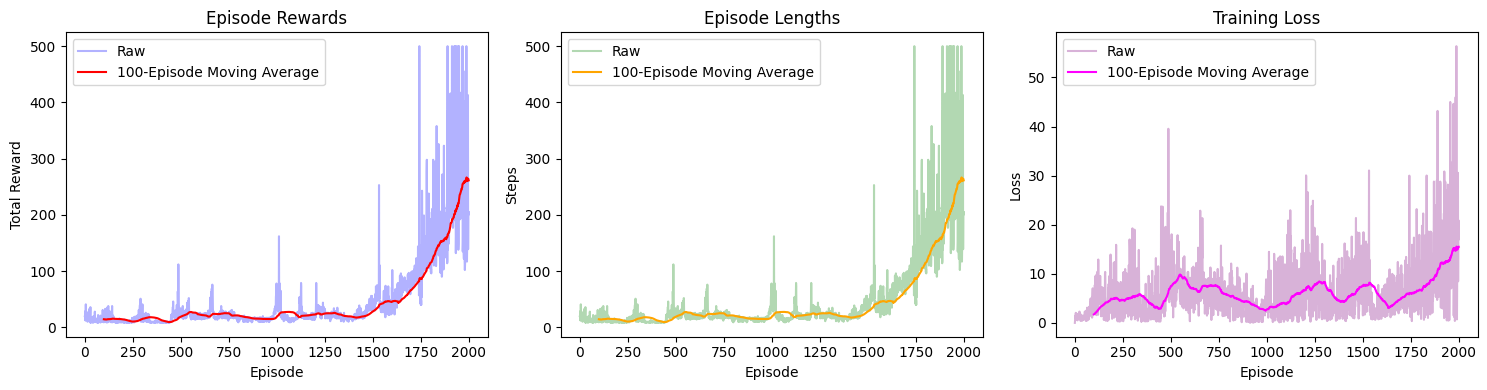

In [22]:
# Create and train the DQN agent
env = create_environment(env_name, **env_args)
dqn_agent = DQNAgent(env,
                     learning_rate=0.001,
                     n_frames=4,  # Specify number of frames to stack
                     memory_size=10000,  # Larger memory for frame stacks
                     batch_size=32)

episode_rewards, episode_lengths, episode_losses = dqn_agent.train(n_episodes=2000, max_steps=500)

# Plot training results including losses
plot_episode_stats(episode_rewards, episode_lengths, episode_losses)


In [23]:

# Modify test_agent function to handle frame stacking
def test_agent(agent, env, n_episodes=5, max_steps=5000):
    episode_rewards = []
    episode_lengths = []

    for episode in range(n_episodes):
        total_reward = 0
        initial_state, _ = env.reset()
        state = agent.frame_stack.reset(initial_state)  # Initialize frame stack
        episode_over = False
        t = 0

        while not episode_over:
            action = agent.act(state)
            next_obs, reward, terminated, truncated, _ = env.step(action)

            # Update frame stack
            state = agent.frame_stack.add_frame(next_obs)

            total_reward += reward
            episode_over = terminated or truncated or t > max_steps
            t += 1

        episode_rewards.append(total_reward)
        episode_lengths.append(t)
        print(f"Episode {episode + 1}: Reward = {total_reward:.2f}, Length = {t}")

    print("\nTest Results:")
    print(f"Average Reward: {np.mean(episode_rewards):.2f} ± {np.std(episode_rewards):.2f}")
    print(f"Average Length: {np.mean(episode_lengths):.2f} ± {np.std(episode_lengths):.2f}")

    return episode_rewards, episode_lengths

In [24]:

# Test the DQN agent
env = create_environment(env_name, record=True, record_path="./video_dqn", **env_args)
test_rewards, test_lengths = test_agent(dqn_agent, env, n_episodes=10)
env.close()

#embed_video("./video_dqn/rl-video-episode-8.mp4")

Moviepy - Building video /kaggle/working/video_dqn/rl-video-episode-0.mp4.
Moviepy - Writing video /kaggle/working/video_dqn/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /kaggle/working/video_dqn/rl-video-episode-0.mp4
Episode 1: Reward = 290.00, Length = 290
Moviepy - Building video /kaggle/working/video_dqn/rl-video-episode-1.mp4.
Moviepy - Writing video /kaggle/working/video_dqn/rl-video-episode-1.mp4



Moviepy - Done !
Moviepy - video ready /kaggle/working/video_dqn/rl-video-episode-1.mp4
Episode 2: Reward = 245.00, Length = 245
Moviepy - Building video /kaggle/working/video_dqn/rl-video-episode-2.mp4.
Moviepy - Writing video /kaggle/working/video_dqn/rl-video-episode-2.mp4



Moviepy - Done !
Moviepy - video ready /kaggle/working/video_dqn/rl-video-episode-2.mp4
Episode 3: Reward = 350.00, Length = 350
Moviepy - Building video /kaggle/working/video_dqn/rl-video-episode-3.mp4.
Moviepy - Writing video /kaggle/working/video_dqn/rl-video-episode-3.mp4



Moviepy - Done !
Moviepy - video ready /kaggle/working/video_dqn/rl-video-episode-3.mp4
Episode 4: Reward = 273.00, Length = 273
Moviepy - Building video /kaggle/working/video_dqn/rl-video-episode-4.mp4.
Moviepy - Writing video /kaggle/working/video_dqn/rl-video-episode-4.mp4



Moviepy - Done !
Moviepy - video ready /kaggle/working/video_dqn/rl-video-episode-4.mp4
Episode 5: Reward = 284.00, Length = 284
Moviepy - Building video /kaggle/working/video_dqn/rl-video-episode-5.mp4.
Moviepy - Writing video /kaggle/working/video_dqn/rl-video-episode-5.mp4



Moviepy - Done !
Moviepy - video ready /kaggle/working/video_dqn/rl-video-episode-5.mp4
Episode 6: Reward = 346.00, Length = 346
Moviepy - Building video /kaggle/working/video_dqn/rl-video-episode-6.mp4.
Moviepy - Writing video /kaggle/working/video_dqn/rl-video-episode-6.mp4



Moviepy - Done !
Moviepy - video ready /kaggle/working/video_dqn/rl-video-episode-6.mp4
Episode 7: Reward = 233.00, Length = 233
Moviepy - Building video /kaggle/working/video_dqn/rl-video-episode-7.mp4.
Moviepy - Writing video /kaggle/working/video_dqn/rl-video-episode-7.mp4



Moviepy - Done !
Moviepy - video ready /kaggle/working/video_dqn/rl-video-episode-7.mp4
Episode 8: Reward = 500.00, Length = 500
Moviepy - Building video /kaggle/working/video_dqn/rl-video-episode-8.mp4.
Moviepy - Writing video /kaggle/working/video_dqn/rl-video-episode-8.mp4



Moviepy - Done !
Moviepy - video ready /kaggle/working/video_dqn/rl-video-episode-8.mp4
Episode 9: Reward = 301.00, Length = 301
Moviepy - Building video /kaggle/working/video_dqn/rl-video-episode-9.mp4.
Moviepy - Writing video /kaggle/working/video_dqn/rl-video-episode-9.mp4



Moviepy - Done !
Moviepy - video ready /kaggle/working/video_dqn/rl-video-episode-9.mp4
Episode 10: Reward = 416.00, Length = 416

Test Results:
Average Reward: 323.80 ± 78.11
Average Length: 323.80 ± 78.11


In [10]:

embed_video("./video_dqn/rl-video-episode-8.mp4") # Restored video for preview, kept above cell for scores

# Conclusions

In conclusion, this report demonstrated the effectiveness of QLearning and Deep QLearning in reinforcement learning tasks. While traditional QLearning is effective in simpler environments, it faces limitations when scaling to more complex, high-dimensional spaces. In contrast, Deep QLearning, by incorporating deep neural networks to approximate Q-values, handles these complexities more effectively, leading to superior performance in challenging environments. The results highlight the advantages of using Deep QLearning for tasks involving large state-action spaces, where traditional methods struggle to generalize. This study underscores the importance of neural network-based approaches in advancing the capabilities of reinforcement learning in dynamic and intricate settings.

## Challenges
Balancing exploration and exploitation is a key challenge in reinforcement learning. Too much exploration can slow down learning, while excessive exploitation may lead to suboptimal solutions. Techniques like epsilon-greedy help manage this trade-off but require careful tuning.

Both QLearning and Deep QLearning are computationally intensive, with Deep QLearning demanding significant resources due to the need for training deep neural networks. This results in longer training times, especially in complex environments, and can be impractical in real-time or resource-limited settings. The trade-off between model performance and computational efficiency is evident in these systems.

## Future work


Future work could involve integrating convolutional neural networks (CNNs) to handle high-dimensional visual input, allowing for more effective learning in environments with rich sensory data. This approach could be applied to classic Atari games, such as Breakout, where CNNs would help the agent better interpret pixel-based states and improve its performance in these complex environments.



